In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, SimpleRNN
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 30
test_date = 304

level_1 = 30
level_2 = 80
level_3 = 150

num_level = 4

pm_target = level_3 * 2
wind_speed_target = 14 # 강한 바람
wind_direction_target = 360 # 16방위

year = 365
train_cut = year * 9 + 1 -30

test_cut = -test_date

In [3]:
### 데이터 로드

data = pd.read_csv('dataset/PM_2.5_dataset_09_19.csv', index_col=0)
data.head()

,PM Seoul,PM Beijing,avg temprature,avg humidity,avg wind speed seoul,max wind direction seoul,avg wind speed back,max wind direction back
date,,,,,,,,
2009-01-01,43.739130,181.083875,-5.8,45.8,2.3,290.0,4.5,320
2009-01-02,45.750000,168.780998,-2.8,51.5,1.6,290.0,4.2,320
2009-01-03,46.833333,177.560185,-1.0,48.3,1.8,20.0,2.8,320
2009-01-04,40.083333,169.828704,0.4,44.3,1.9,290.0,3.1,290
2009-01-05,58.541667,140.598765,-1.6,53.1,2.2,290.0,5.0,290


In [4]:
pm_seoul_data = data['PM Seoul'].values
pm_beijing_data = data['PM Beijing'].values
wind_speed_seoul_data = data['avg wind speed seoul'].values
wind_direction_seoul_data = data['max wind direction seoul'].values
wind_speed_back_data = data['avg wind speed back'].values
wind_direction_back_data = data['max wind direction back'].values

In [5]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return temp_data

In [6]:
def pm_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / pm_target)
        
    return norm_data

In [7]:
pm_seoul_data.shape

(3956,)

In [8]:
norm_pm_seoul = np.array(make_sequential(pm_norm_window(pm_seoul_data)))

In [9]:
norm_result = norm_pm_seoul  
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3256, 30, 1) (366, 30, 1) (304, 30, 1)
(3256, 1) (366, 1) (304, 1)


MODEL_SAVE_FOLBER_PATH = './model/checkpoint/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

# 모델 불러오기
model = load_model('model/PM_prediction_model_achi_0.h5')

In [10]:
model = Sequential()

for i in range (1):
    model.add(SimpleRNN(32, return_sequences=False, input_shape=(seq_len, 1)))   
    model.add(Dropout(0.5))

#model.add(LSTM(30, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.summary()

W1114 17:37:26.534998 21460 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1114 17:37:26.550993 21460 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1114 17:37:26.552993 21460 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1114 17:37:26.620987 21460 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1114 17:37:26.626977 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [11]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='mse', optimizer='adam')

hist=model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=100, epochs=50)

W1114 17:37:31.111535 21460 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1114 17:37:31.290479 21460 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3256 samples, validate on 366 samples
Epoch 1/50
3256/3256 [==============================] - 2s 730us/step - loss: 0.1016 - val_loss: 0.0142
Epoch 2/50
3256/3256 [==============================] - 1s 228us/step - loss: 0.0361 - val_loss: 0.0092
Epoch 3/50
3256/3256 [==============================] - 1s 217us/step - loss: 0.0281 - val_loss: 0.0075
Epoch 4/50
3256/3256 [==============================] - 1s 216us/step - loss: 0.0244 - val_loss: 0.0067
Epoch 5/50
3256/3256 [==============================] - 1s 224us/step - loss: 0.0203 - val_loss: 0.0055
Epoch 6/50
3256/3256 [==============================] - 1s 223us/step - loss: 0.0175 - val_loss: 0.0049
Epoch 7/50
3256/3256 [==============================] - 1s 225us/step - loss: 0.0147 - val_loss: 0.0044
Epoch 8/50
3256/3256 [==============================] - 1s 224us/step - loss: 0.0137 - val_loss: 0.0041
Epoch 9/50
3256/3256 [==============================] - 1s 223us/step - loss: 0.0134 - val_loss: 0.0037
Epoch 10/50
3256/

from keras.models import load_model

# 모델 저장

model. save('model/pm_prediction_model_achi_0.h5')


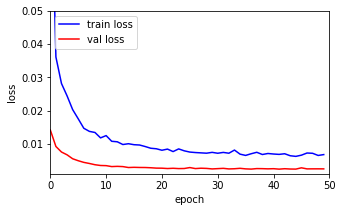

In [12]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.xlim([0, 50])
plt.ylim([0.001, 0.05])

plt.show()

In [13]:
## 결과 실제화
y_true = pm_seoul_data[test_cut:]

pred = model.predict(x_test)

y_pred = pred * pm_target

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


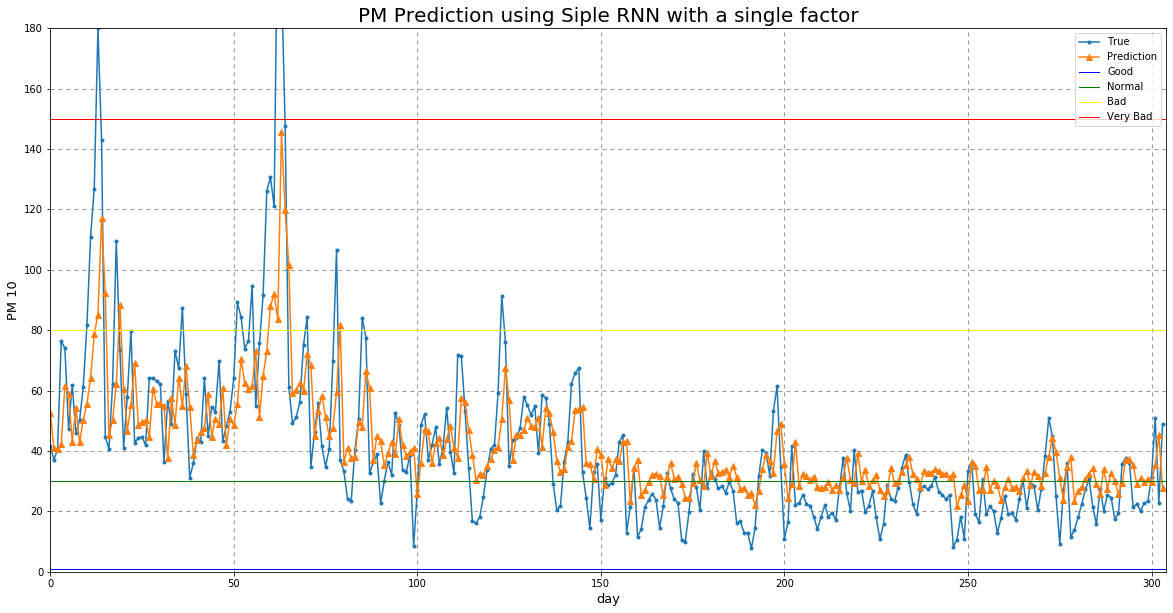

In [14]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction using Siple RNN with a single factor', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=level_1, color='green', linewidth=1, label='Normal')
plt.axhline(y=level_2, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=level_3, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 10', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 180])

ax.legend()
plt.show()

In [15]:
def pm_level(pm):

    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif level_1 < pm[i] <= level_2:
            level_temp.append(2)
        elif level_2 < pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [16]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [17]:
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Veray Bad' accuracy:", level_acc[3])

total accuracy: 0.6414473684210527
level 'Good' accuracy: 0.4076923076923077
level 'Normal' accuracy: 0.9019607843137255
level 'Bad' accuracy: 0.2222222222222222
level 'Veray Bad' accuracy: 0.0
